In [125]:
# Written by: Kirtan Patel AE19B038
#
# PURPOSE
# - Compute the integral expression for constant strength source panels
# - Source panel strengths are constant, but can change from panel to panel
# - Geometric integral for panel-normal    : I(ij)
# - Geometric integral for panel-tangential: J(ij)
# - Compute the Pressure Coefficient at control points of the panels
#
# INPUTS
# - numP   : Number of panels in which we divide the surface
# 
# OUTPUTS
# - Pressure Coefficient at control points of the panels

import numpy as np
import math as math

Then we define the known parameters. <br /> 
In our case, the Angle of Attack(AoA) is irrelevent since a cylinder cross section as infinite symmetries

In [126]:
R = 1                                # Radius of the Cylinder
Vinf = 1                             # Freestream velocity
AoA  = 0                             # Angle of attack [deg]
numP = 12                            # Number of Panels (control points)
AoAR = np.radians(AoA)               # Convert AoA to radians [rad]

To Compute the values of panel source strengths $\lambda$<sub>i</sub> , We need to calculate the integrals I<sub>i,j</sub> and J<sub>i,j</sub>. These are dependent only on the geometry of the object in the flow field.

In [127]:
# %% CREATE CIRCLE BOUNDARY POINTS

# Angles used to compute boundary points (for n panels, we need n+1 boundary points)
# Create angles for computing boundary point locations [deg]
theta = np.linspace(0,360,num = numP+1)      
theta = np.radians(theta)                    # Convert from degrees to radians [rad]

Computed boundary point coordinates are returned in *anticlockwise* direction <br />
This orientation causes the normal to the surface to point inward (inside the body) <br />
Since we dont want that, we reverse the co-ordinated to get panels in *clockwise* orientation, with outward normal


In [128]:
# Reversing boundary points to get an outward normal.
XB_aclck = R*np.cos(theta)                  
YB_aclck = R*np.sin(theta)                  

XB = XB_aclck[::-1]           
YB = YB_aclck[::-1]


We then find the other Geomtrical Characteristic Features of the Panel Geometry

In [129]:
# %% PANEL METHOD GEOMETRY

# Initialize variables
XC  = np.zeros(numP)                # Initialize control point coordinates arrays
YC  = np.zeros(numP)                
S   = np.zeros(numP)                # Initialize panel length array
phi = np.zeros(numP)                # Initialize panel orientation angle array

# Find geometric quantities of the airfoil
for i in range(numP):                         # Loop over all panels
    XC[i]   = 0.5*(XB[i]+XB[i+1])             # values of control point
    YC[i]   = 0.5*(YB[i]+YB[i+1])             
    dx      = XB[i+1]-XB[i]                   # Change between boundary points
    dy      = YB[i+1]-YB[i]                   
    S[i]    = (dx**2 + dy**2)**0.5            # Length of the panel
    phi[i]  = math.atan2(dy,dx)               # Angle of panel 
    if (phi[i] < 0):                          # Make all panel angles positive [rad]
        phi[i] = phi[i] + 2*np.pi
        

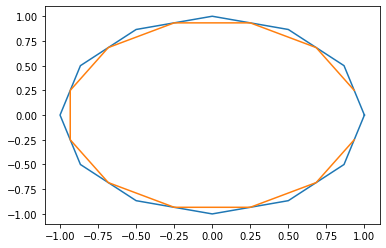

In [130]:
# To check the geometry created of the object in the flow, we plot it
import matplotlib.pyplot as plt
plt.plot(XB,YB)   #plots boundary points
plt.plot(XC,YC)   #plots control points

Now that we have the object parameters, calculating the integrals I<sub>i,j</sub> and J<sub>i,j</sub>.  <br />
This section of the code is inspired from the solved example in the book : <br />
$$ Fundamentals~of~Aerodynamics - John~D~Anderson $$

In [131]:
# Initialize arrays
I = np.zeros([numP,numP])         # Initialize I integral matrix
J = np.zeros([numP,numP])         # Initialize J integral matrix
 
# Computing integral by looping over panels
for i in range(numP):                                                         
    for j in range(numP):                                                       
        if (j != i):                                                            
            # Compute intermediate values
            A  = -(XC[i]-XB[j])*np.cos(phi[j])-(YC[i]-YB[j])*np.sin(phi[j])     # A term
            B  = (XC[i]-XB[j])**2 + (YC[i]-YB[j])**2                            # B term
            C = np.sin(phi[i]-phi[j])                                           # C term 
            D = (YC[i]-YB[j])*np.cos(phi[i])-(XC[i]-XB[j])*np.sin(phi[i])       # D term 
            E  = np.sqrt(B-A**2)                                                # E term
                                                        
            # Zero out any problem values i.e If E term is 0 or complex or a NAN or an INF 
            if (E == 0 or np.iscomplex(E) or np.isnan(E) or np.isinf(E)):       
                 I[i,j] = 0                                                     # Set I value equal to zero
                 J[i,j] = 0                                                     # Set J value equal to zero
            else:
               # Compute I (needed for normal velocity), Ref [1]
                term1  = 0.5*C*np.log((S[j]**2 + 2*A*S[j] + B)/B)               # First term in I equation
                term2  = ((D-A*C)/E)*(math.atan2((S[j]+A),E)-math.atan2(A,E))   # Second term in I equation
                I[i,j] = term1 + term2                                          # Compute I integral
                
                # Compute J (needed for tangential velocity), Ref [2]
                term1  = ((D-A*C)/(2*E))*np.log((S[j]**2 + 2*A*S[j] + B)/B)     # First term in J equation
                term2  = ((-1)*C)*(math.atan2((S[j]+A),E)-math.atan2(A,E))      # Second term in J equation
                J[i,j] = term1 + term2                                          # Compute J integral
              
        # Zero out any problem values i.e if term is NON or INF, setting them to zero
        if (np.iscomplex(I[i,j]) or np.isnan(I[i,j]) or np.isinf(I[i,j])):      
            I[i,j] = 0                                                          
        if (np.iscomplex(J[i,j]) or np.isnan(J[i,j]) or np.isinf(J[i,j])):      
            J[i,j] = 0                                                          
       
  #These are values of I and J.

$$Normal~Flow$$
From the Boundary Condition that no flow is across the panel, we get the equation :
$$ V_{panels,n} + V_{\infty,n} = 0 $$
which gives
$$\sum \limits _{j=1, j{\neq}i} ^{n} \frac{\lambda_{j}}{2 \pi} \int_{j} \frac{\partial(ln(r_{ij}))}{\partial n_i}ds_j ~+~ \frac{\lambda_i}{2} ~+~ V_{\infty} cos(\beta_i)= 0 $$

substituting the integral,

$$ I_{ij} ~=~ \frac{\lambda_{j}}{2 \pi} \int_{j} \frac{\partial(ln(r_{ij}))}{\partial n_i}ds_j $$

 we get a system of n equations (corresponding to n panels) with n variables ($\lambda_i$) :
$$\sum \limits _{j=1, j{\neq}i} ^{n} \frac{\lambda_{j}}{2 \pi}I_{ij} ~+~ \frac{\lambda_i}{2} ~+~ V_{\infty} cos(\beta_i)= 0 $$
<br />
To solve these simultaneously, we use matrices.


$$
\left[\begin{array}{ccc}
\frac{1}{2} & \frac{I_{12}}{2\pi}& \frac{I_{13}}{2\pi} &..& \frac{I_{1n}}{2\pi}\\
\frac{I_{12}}{2\pi} & \frac{1}{2}& \frac{I_{13}}{2\pi}  &..&..\\
\frac{I_{13}}{2\pi}  &\frac{I_{13}}{2\pi}  & \frac{1}{2}  &..&.. \\
 ...  & ... & ... &.. & ..\\
  ..  & ... & ... &..  & \frac{1}{2}\\
\end{array}\right]
\left[\begin{array}{ccc}
\lambda_1 \\
\lambda_2 \\
.. \\
.. \\
.. \\
\lambda_n 
\end{array}\right]
= (-V_{\infty,n})
\left[\begin{array}{ccc}
cos(\beta_1) \\
cos(\beta_1) \\
.. \\
.. \\
.. \\
cos(\beta_n)
\end{array}\right]
$$ 

which we solve to get the values of strength ($\lambda_i$) <br/>
<br/>
$$Tangential~Flow$$

With the strength of the sources found, we can find the tangential velocity over the panels

$$ V_i =  V_{panels,s} + V_{\infty,s}$$

$$V_i = \sum \limits _{j=1, j{\neq}i} ^{n} \frac{\lambda_{j}}{2 \pi} \int_{j} \frac{\partial(ln(r_{ij}))}{\partial s_i}ds_j ~+~ V_{\infty} sin(\beta_i)$$


the $\lambda_i$ term drops since the self-contribution of the panel is zero in the tangential direction.substituting the integral,

$$ J_{ij} ~=~ \int_{j} \frac{\partial(ln(r_{ij}))}{\partial s_i}ds_j  $$

We solve this using matrix multiplication to get $V_i$

$$
\left[\begin{array}{ccc}
0 & \frac{J_{12}}{2\pi}& \frac{J_{13}}{2\pi} &..& \frac{J_{1n}}{2\pi}\\
\frac{J_{12}}{2\pi} & 0& \frac{J_{13}}{2\pi}  &..&..\\
\frac{J_{13}}{2\pi}  &\frac{J_{13}}{2\pi}  & 0  &..&.. \\
 ...  & ... & ... &.. & ..\\
  ..  & ... & ... &..  & 0\\
\end{array}\right]
\left[\begin{array}{ccc}
\lambda_1 \\
\lambda_2 \\
.. \\
.. \\
.. \\
\lambda_n 
\end{array}\right]
+ V_{\infty}
\left[\begin{array}{ccc}
sin(\beta_1) \\
sin(\beta_1) \\
.. \\
.. \\
.. \\
sin(\beta_n)
\end{array}\right]
$$ 
<br/>
We can eliminate $\beta$ from the equation, using the relations we obtain from the geometry of the panels
$$ \beta = \phi + \frac{\pi}{2}$$
and hence
$$ cos(\beta) = -sin(\phi)$$
$$ sin(\beta) = cos(\phi)$$

In [132]:
# Using the above calculated values of I[i,j] and J[i,j],
# we form a matrix equation of the system of n equations and n variables (n=numP)
mat_I = np.zeros([numP,numP])                                        
mat_J = np.zeros([numP,numP])    

for i in range(numP):
    for j in range(numP):
        mat_J[i,j] = (J[i,j])/(2*math.pi)
        mat_I[i,j] = (I[i,j])/(2*math.pi)
        if(i==j):
            mat_I[i,j]=0.5
            mat_J[i,j]=0

#and the other matrix in the equation
b  = np.zeros(numP)                # Initialize control point X-coordinate

for i in range(numP):
    b[i] = Vinf*math.sin(phi[i])
    # to remove precision error
    if(-math.pow(10,-15) < b[i] < math.pow(10,-15)):
        b[i] = 0

In [133]:
# Solving for strength

# strength = np.linalg.inv(mat_I).dot(b)
strength = np.linalg.solve(mat_I, b)

sum=0
for i in range(numP):
    sum = sum+strength[i]
    # to remove precision error
    if(-math.pow(10,-15) < strength[i] < math.pow(10,-15)):
        strength[i]=0

# to remove precision error
if(-math.pow(10,-15) < sum < math.pow(10,-15)):
    sum =0

#for equal area panels, sum of strenghths = 0 . If not, solution is wrong

In [134]:
# Solving for Vi

Vs  = np.zeros(numP)                # Initialize contribution of freestream velocity 
V  = np.zeros(numP)                 # Initialize velocity over control points
Cp  = np.zeros(numP)                # Initialize pressure coefficients over control points


for i in range(numP):
    Vs[i] = Vinf*math.cos(phi[i])

V = np.matmul(mat_J,strength) + Vs

We obtain the Pressure Coefficient over the panels using the following formula:
$$ C_{p,i} = 1 - (\frac{V_i}{V_{\infty}})^2$$

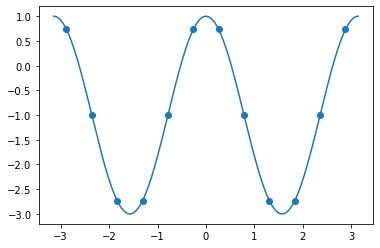

In [135]:
# Calculating Pressure Coefficient
for i in range(numP):
    Cp[i] = 1 - math.pow((V[i]/Vinf),2)


angle_control_point = np.zeros(numP)                              # Initialize panel orientation angle array
for i in range(numP):
    angle_control_point[i]  = math.atan2(YC[i],XC[i])              # Angle of control panel 
plt.scatter(angle_control_point,Cp)
    
# Plotting the Analytically obtained Function for reference
psi = np.linspace(-math.pi,1*math.pi,10000)
function  = np.zeros(10000)                                       # Initialize the Analytical function values 

for i in range(10000):
    function[i] = 1 - 4*math.pow(math.sin(psi[i]),2)
    
plt.plot(psi,function)